In [1]:
import os
import sys
import re
import json
import numpy as np
import pandas as pd
from collections import defaultdict

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../onmt'))
if module_path not in sys.path:
    sys.path.append(module_path)

import kp_evaluate
import onmt.keyphrase.utils as utils

import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from nltk.stem.porter import *
stemmer = PorterStemmer()

def stem_word_list(word_list):
    return [stemmer.stem(w.strip()) for w in word_list]

def if_present_duplicate_phrases(src_seq, tgt_seqs, stemming=True, lowercase=True):
    """
    Check if each given target sequence verbatim appears in the source sequence
    :param src_seq:
    :param tgt_seqs:
    :param stemming:
    :param lowercase:
    :param check_duplicate:
    :return:
    """
    if lowercase:
        src_seq = [w.lower() for w in src_seq]
    if stemming:
        src_seq = stem_word_list(src_seq)

    present_indices = []
    present_flags = []
    duplicate_flags = []
    phrase_set = set()  # some phrases are duplicate after stemming, like "model" and "models" would be same after stemming, thus we ignore the following ones

    for tgt_seq in tgt_seqs:
        if lowercase:
            tgt_seq = [w.lower() for w in tgt_seq]
        if stemming:
            tgt_seq = stem_word_list(tgt_seq)

        # check if the phrase appears in source text
        # iterate each word in source
        match_flag, match_pos_idx = if_present_phrase(src_seq, tgt_seq)

        # if it reaches the end of source and no match, means it doesn't appear in the source
        present_flags.append(match_flag)
        present_indices.append(match_pos_idx)

        # check if it is duplicate
        if '_'.join(tgt_seq) in phrase_set:
            duplicate_flags.append(True)
        else:
            duplicate_flags.append(False)
        phrase_set.add('_'.join(tgt_seq))

    assert len(present_flags) == len(present_indices)

    return np.asarray(present_flags), \
           np.asarray(present_indices), \
           np.asarray(duplicate_flags)

def if_present_phrase(src_str_tokens, phrase_str_tokens):
    """

    :param src_str_tokens: a list of strings (words) of source text
    :param phrase_str_tokens: a list of strings (words) of a phrase
    :return:
    """
    match_flag = False
    match_pos_idx = -1
    for src_start_idx in range(len(src_str_tokens) - len(phrase_str_tokens) + 1):
        match_flag = True
        # iterate each word in target, if one word does not match, set match=False and break
        for seq_idx, seq_w in enumerate(phrase_str_tokens):
            src_w = src_str_tokens[src_start_idx + seq_idx]
            if src_w != seq_w:
                match_flag = False
                break
        if match_flag:
            match_pos_idx = src_start_idx
            break

    return match_flag, match_pos_idx


## Stats of Four Transfer Datasets

#### KP20k-train
    num_doc= 514154
    avg_src_len= 161.00254203993356
    num_tgt= 2710067
    num_unique_tgt= 680136
    avg_tgt_len= 2.0392241225032444
    num_present_doc= 489040
    num_present_tgt= 1715640 , #avg=3.34
    num_absent_doc= 420673
    num_absent_tgt= 994427 , #avg=1.93
    
#### OpenKP-train
    num_doc= 134894
    avg_src_len= 1104.5965647100686
    num_tgt= 294186
    num_unique_tgt= 206806
    avg_tgt_len= 1.9732210234341538
    num_present_doc= 134894
    num_present_tgt= 288417 , #avg=2.14
    num_absent_doc= 5095
    num_absent_tgt= 5769 , #avg=0.04
    
 
#### KPTimes-train   
    num_doc= 259923
    avg_src_len= 803.653481992744
    num_tgt= 1308180
    num_unique_tgt= 104797
    avg_tgt_len= 2.1985628888990814
    num_present_doc= 232110
    num_present_tgt= 628506 , #avg=2.42
    num_absent_doc= 242719
    num_absent_tgt= 679674 , #avg=2.61

#### Stackex
    num_doc= 298965
    avg_src_len= 207.50310571471576
    num_tgt= 803868
    num_unique_tgt= 8102
    avg_tgt_len= 1.3293140167291146
    num_present_doc= 252114
    num_present_tgt= 464119 , #avg=1.55
    num_absent_doc= 204656
    num_absent_tgt= 339749 , #avg=1.14

In [6]:
from collections import defaultdict

dataset_names = ['kp20k', 'openkp', 'kptimes', 'stackex']
# dataset_names = ['kp20k', 'openkp']

KP_DATASET_FIELDS = {'kp20k': ('title', 'abstract', 'keywords', None),
                     'stackex': ('title', 'question', 'tags', 'categories'),
                     'openkp': ('url', 'text', 'KeyPhrases', None),
                     'kptimes': ('title', 'abstract', 'keyword', 'categories')}
dataset_split = 'train'
json_base_dir = '/zfs1/hdaqing/rum20/kp/data/kp/json' # path on CRC

dataset_src_lens, dataset_tgt_lens, dataset_tgt_nums  = {}, {}, {}    
dataset_unique_kp_count, dataset_unique_preskp_count, dataset_unique_abskp_count = {}, {}, {}

for dataset_name in dataset_names:
    src_len, tgt_len, tgt_num = [], [], []
    num_present_doc, num_present_tgt = 0, 0
    num_absent_doc, num_absent_tgt = 0, 0
    
    unique_kp_count, unique_preskp_count, unique_abskp_count = defaultdict(int), defaultdict(int), defaultdict(int)
    print(dataset_name)

    input_json_path = os.path.join(json_base_dir, dataset_name, '%s.json' % dataset_split)
    
    with open(input_json_path, 'r') as input_json:
        for ex_id, json_line in enumerate(input_json):
            if ex_id % 10000 == 0: print(ex_id)
            ex_dict = json.loads(json_line)
            
            title_field, text_field, keyword_field, _ = KP_DATASET_FIELDS[dataset_name]

            src_str = ex_dict[title_field] + ' . ' + ex_dict[text_field]
            if isinstance(ex_dict[keyword_field], str):
                tgt_kps = ex_dict[keyword_field].split(';')
            else:
                tgt_kps = ex_dict[keyword_field]

            src_seq = [t for t in re.split(r'\W', src_str) if len(t) > 0]
            tgt_seqs = [[t for t in re.split(r'\W', p) if len(t) > 0] for p in tgt_kps]
#             [kp_set.add(' '.join(p)) for p in tgt_seqs]
            
            present_tgt_flags, _, _ = if_present_duplicate_phrases(src_seq, tgt_seqs, stemming=True, lowercase=True)
            
            present_tgts = [tgt for tgt, present in zip(tgt_seqs, present_tgt_flags) if present]
            absent_tgts = [tgt for tgt, present in zip(tgt_seqs, present_tgt_flags) if ~present]
            
            for p in tgt_seqs:
                unique_kp_count[' '.join(p)] += 1
            for p in present_tgts:
                unique_preskp_count[' '.join(p)] += 1
            for p in absent_tgts:
                unique_abskp_count[' '.join(p)] += 1
            
            num_present_tgt += len(present_tgts)
            num_absent_tgt += len(absent_tgts)
            if len(present_tgts) > 0: num_present_doc += 1
            if len(absent_tgts) > 0: num_absent_doc += 1
                                 
            src_len.append(len(src_seq))
            tgt_num.append(len(tgt_seqs))
            tgt_len.extend([len(tgt_seq) for tgt_seq in tgt_seqs])
    
    print('num_doc=', len(src_len))
    print('avg_src_len=', np.mean(src_len))
    print('num_tgt=', sum(tgt_num))
    print('num_unique_tgt=', len(unique_kp_count))
    print('avg_tgt_len=', np.mean(tgt_len))
    print('num_present_doc=', num_present_doc)
    print('num_present_tgt=', num_present_tgt, ', #avg=%.2f' % (num_present_tgt / len(tgt_num)))
    print('num_absent_doc=', num_absent_doc)
    print('num_absent_tgt=', num_absent_tgt, ', #avg=%.2f' % (num_absent_tgt / len(tgt_num)))

    dataset_src_lens[dataset_name] = src_len
    dataset_tgt_lens[dataset_name] = tgt_len
    dataset_tgt_nums[dataset_name] = tgt_num
    dataset_unique_kp_count[dataset_name] = unique_kp_count
    dataset_unique_preskp_count[dataset_name] = unique_preskp_count
    dataset_unique_abskp_count[dataset_name] = unique_abskp_count


kp20k
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
num_doc= 514154
avg_src_len= 161.00254203993356
num_tgt= 2710067
num_unique_tgt= 680136
avg_tgt_len= 2.0392241225032444
num_present_doc= 489040
num_present_tgt= 1715640 , #avg=3.34
num_absent_doc= 420673
num_absent_tgt= 994427 , #avg=1.93
openkp
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
num_doc= 134894
avg_src_len= 1104.5965647100686
num_tgt= 294186
num_unique_tgt= 206806
avg_tgt_len= 1.9732210234341538
num_present_doc= 134894
num_present_tgt= 288417 , #avg=2.14
num_absent_doc= 5095
num_absent_tgt= 5769 , #avg=0.04
kptimes
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120

In [7]:
# SAVE pred/eval paths and dataframes
%store dataset_src_lens
%store dataset_tgt_lens
%store dataset_tgt_nums
%store dataset_unique_kp_count
%store dataset_unique_preskp_count
%store dataset_unique_abskp_count

# LOAD using store magic (doesn't work on Colab)
%store -r dataset_src_lens
%store -r dataset_tgt_lens
%store -r dataset_tgt_nums
%store -r dataset_unique_kp_count
%store -r dataset_unique_preskp_count
%store -r dataset_unique_abskp_count

Stored 'dataset_src_lens' (dict)
Stored 'dataset_tgt_lens' (dict)
Stored 'dataset_tgt_nums' (dict)
Stored 'dataset_unique_kp_count' (dict)
Stored 'dataset_unique_preskp_count' (dict)
Stored 'dataset_unique_abskp_count' (dict)


### Common absent phrases in each dataset

In [9]:
for dataset, kp_set in dataset_unique_abskp_count.items():
    print('*' * 50)
    print(dataset, len(kp_set))
    kp_list = sorted(kp_set.items(), key=lambda k:k[1], reverse=True)
    
    for p in kp_list[:20]:
        print(p)


**************************************************
kp20k 393767
('algorithms', 2134)
('data mining', 2020)
('design', 1841)
('machine learning', 1727)
('performance', 1387)
('experimentation', 1338)
('theory', 1308)
('performance evaluation', 1245)
('information retrieval', 1157)
('cryptography', 1106)
('reliability', 1095)
('pattern recognition', 1092)
('finite element method', 1085)
('computational complexity', 1064)
('image processing', 1038)
('security', 986)
('verification', 973)
('classification', 924)
('optimization', 915)
('cybernetics', 896)
**************************************************
openkp 5154
('Baby Names', 41)
('Definition', 23)
('Dictionary', 21)
('United States', 20)
('mean', 19)
('Think Baby Names', 19)
('definitions', 16)
('Holiday Inn', 16)
('FCRA', 15)
('Recipes', 13)
('definition', 13)
('DIN', 10)
('CHLORHEXADINE SOLUTION', 10)
('Lee High School', 10)
('Fairfax County Public Schools', 10)
('Lyme Disease Association', 10)
('Definitions', 9)
('Synonyms', 9)
('

### Cherry-pick transfered labels

In [1]:
import random
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../onmt'))
if module_path not in sys.path:
    sys.path.append(module_path)
import onmt.keyphrase.eval as eval
import importlib
importlib.reload(eval)
import json


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
dataset_names = ['kp20k_train100k', 'openkp_train100k', 'kptimes_train100k', 'stackex_train100k']

KP_DATASET_FIELDS = {'kp20k': ('title', 'abstract', 'keywords', None),
                     'stackex': ('title', 'question', 'tags', 'categories'),
                     'openkp': ('url', 'text', 'KeyPhrases', None),
                     'kptimes': ('title', 'abstract', 'keyword', 'categories')}

examples_dict = {}

for dataset_name in dataset_names:
    input_path = '/zfs1/hdaqing/rum20/kp/data/kp/json/%s/train.json' % dataset_name
    tl_path = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_bart_DA/bart_kppretrain_wiki_1e5_controlled/outputs/beamsearch-width_1-maxlen_40/pred/checkpoint_step_100000-data_%s_train.pred' % dataset_name
    dataset_name = dataset_name[: dataset_name.index('_')]
    print(dataset_name)
    examples_dict[dataset_name] = []

    with open(input_path, 'r') as input_json, open(tl_path, 'r') as tl_json:
        for ex_id, (json_line, tl_line) in enumerate(zip(input_json, tl_json)):
            ex_dict = json.loads(json_line)
            tl_dict = json.loads(tl_line)

            title_field, text_field, keyword_field, _ = KP_DATASET_FIELDS[dataset_name]

            if isinstance(ex_dict[keyword_field], str):
                tgt_kps = ex_dict[keyword_field].split(';')
            else:
                tgt_kps = ex_dict[keyword_field]

            _ex_dict = {}
            _ex_dict['title'] = ex_dict[title_field]
            _ex_dict['text'] = ex_dict[text_field]
            _ex_dict['keyphrase'] = tgt_kps
            tl_kps = [' '.join(p) for p in tl_dict['pred_sents'] if len(p) > 0]
            _ex_dict['transfered_keyphrase'] = tl_kps
    #         print(tgt_kps)
    #         print(tl_kps)

            examples_dict[dataset_name].append(_ex_dict)
            if ex_id > 10000: break


kp20k
openkp
kptimes
stackex


#### kp20k

2123

In [4]:
rnd_idx = random.randint(0, len(examples_dict['kp20k'])-1)
print(rnd_idx)
ex_dict = examples_dict['kp20k'][2123]
src_text = ex_dict['title'] + ' . ' + ex_dict['text']
printout, eval_dict = eval.eval_and_print(src_text, 
                                          tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], 
                                          pred_scores=None, return_eval=True)
print(printout)

'''
for ex_idx, ex_dict in enumerate(examples_dict['kp20k']):
    if ex_idx < 2000:
        continue
    if ex_idx > 3000:
        break
        
    src_text = ex_dict['title'] + ' . ' + ex_dict['text']
    printout, eval_dict = eval.eval_and_print(src_text, 
                                              tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], 
                                              pred_scores=None, return_eval=True)
    
    if eval_dict['absent_exact']['f_score@50'] > 0.0:
        print(ex_idx)
        print(printout)
'''

7906
[Source]: enriched human-centered multimedia computing through inspirations from disabilities and deficit-centered computing solutions . The paradigm of human-centered multimedia computing (HCMC) has emerged recently as a result of the increasing emphasis on integrating the concept of human-centeredness in various aspects of multimedia computing. While many theories have been proposed to advance this paradigm, it is our belief that a complete understanding of the issues surrounding HCMC requires capturing a complementary (yet enriching) perspective through inspirations drawn from studying human disabilities and deficits. In this paper, we present the need for understanding human deficiencies in sensory, neural, and cognitive sensing/actuations which could reveal innate components of human interaction that benefits researchers, designers and developers of new multimedia solutions. We illustrate how technologies that were started with assistive and rehabilitative goals have broader 

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


"\nfor ex_idx, ex_dict in enumerate(examples_dict['kp20k']):\n    if ex_idx < 2000:\n        continue\n    if ex_idx > 3000:\n        break\n        \n    src_text = ex_dict['title'] + ' . ' + ex_dict['text']\n    printout, eval_dict = eval.eval_and_print(src_text, \n                                              tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], \n                                              pred_scores=None, return_eval=True)\n    \n    if eval_dict['absent_exact']['f_score@50'] > 0.0:\n        print(ex_idx)\n        print(printout)\n"

#### openkp
127 celebrity, inferred personal life

1723 coined a place in PA: Battlinville Pennsylvania 

1803 infered Food Safety Council

2494 inferred election and Minnesota State Capitol

2541 inferred Traditional IRA, Personal financial problems, Financial savers 

In [5]:
ex_dict = examples_dict['openkp'][2541]
src_text = ex_dict['title'] + ' . ' + ex_dict['text']
printout, eval_dict = eval.eval_and_print(src_text, 
                                          tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], 
                                          pred_scores=None, return_eval=True)
print(printout)
'''
count = 0
for ex_idx, ex_dict in enumerate(examples_dict['openkp']):
    if ex_idx < 2000:
        continue
    if ex_idx > 3000:
        break
        
    if len(ex_dict['keyphrase']) < 3: continue

    src_text = ex_dict['title'] + ' . ' + ex_dict['text']
    printout, eval_dict = eval.eval_and_print(src_text, 
                                              tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], 
                                              pred_scores=None, return_eval=True)
    
    if eval_dict['present_exact']['f_score@k'] > 0.4:
        print(ex_idx)
        print(printout)
        count += 1
        if count > 100:
            break
'''


[Source]: http://budgeting.thenest.com/pay-penalty-early-withdrawal-thrift-savings-plan-college-tuition-taxes-24837.html . Calculate Tax Savings Do I Pay a Penalty on Early Withdrawal From a Thrift Savings Plan for College Tuition on My Taxes ? by Naomi Smith You have other options besides taking an early TSP withdrawal for college expenses . For most federal and military employees , the Thrift Savings Plan offers comparable benefits to private - sector individual retirement accounts and 401 ( k ) plans . However , the options for penalty - free early withdrawals are not as generous as with other retirement plans . The TSP allows you to withdraw your money early , but if it ' s going for college tuition you ' ll get stuck with a 10 percent penalty as well as any taxes owed on the distribution . You may find other options more advantageous . Early Withdrawal An early withdrawal is defined as any distribution from your TSP before you reach retirement age : 59 ½ for federal employees , or

"\ncount = 0\nfor ex_idx, ex_dict in enumerate(examples_dict['openkp']):\n    if ex_idx < 2000:\n        continue\n    if ex_idx > 3000:\n        break\n        \n    if len(ex_dict['keyphrase']) < 3: continue\n\n    src_text = ex_dict['title'] + ' . ' + ex_dict['text']\n    printout, eval_dict = eval.eval_and_print(src_text, \n                                              tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], \n                                              pred_scores=None, return_eval=True)\n    \n    if eval_dict['present_exact']['f_score@k'] > 0.4:\n        print(ex_idx)\n        print(printout)\n        count += 1\n        if count > 100:\n            break\n"

#### KPTimes
- 959 inferred topics about Illegal immigration
- 1134 education
- 1199 apple tech
- 2518 Charter Challenges Comcast-Time Warner Cable Deal inferred Mergers and acquisitions

In [9]:
ex_dict = examples_dict['kptimes'][1199]
src_text = ex_dict['title'] + ' . ' + ex_dict['text']
printout, eval_dict = eval.eval_and_print(src_text, 
                                          tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], 
                                          pred_scores=None, return_eval=True)
print(printout)
'''
count = 0
for ex_idx, ex_dict in enumerate(examples_dict['kptimes']):
    if ex_idx < 1000:
        continue
    if ex_idx > 2000:
        break
        
    if len(ex_dict['keyphrase']) < 3: continue

    src_text = ex_dict['title'] + ' . ' + ex_dict['text']
    printout, eval_dict = eval.eval_and_print(src_text, 
                                              tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], 
                                              pred_scores=None, return_eval=True)
    
    if eval_dict['absent_exact']['f_score@50'] > 0.0:
        print(ex_idx)
        print(printout)
        count += 1
        if count > 100:
            break
'''


[Source]: Apple Profit Soars 73% as Sales Rise . SAN FRANCISCO, July 25 — Apple on Wednesday reported a 73 percent jump in quarterly profit on strong sales of Macs and iPods, beating Wall Street forecasts. It also alleviated some concerns about early sales of the iPhone . Investors were spooked on Tuesday when AT&T, which provides service for the phone, said it had activated just 146,000 iPhones in the day and a half from its release to the end of the quarter, far fewer than some analysts had expected. That sent Apple’s stock down 6 percent. But Apple executives said on Wednesday that the company had actually sold 270,000 iPhones in that period, a number that seemed to calm investors’ fears. The executives said Apple expects to sell 1 million iPhones this quarter, and reiterated its goal of selling 10 million phones by the end of 2008. The company plans to release the phone in Europe in the fourth quarter. “Our view is the starting gun has been fired and we’re off to a great start,” sa

"\ncount = 0\nfor ex_idx, ex_dict in enumerate(examples_dict['kptimes']):\n    if ex_idx < 1000:\n        continue\n    if ex_idx > 2000:\n        break\n        \n    if len(ex_dict['keyphrase']) < 3: continue\n\n    src_text = ex_dict['title'] + ' . ' + ex_dict['text']\n    printout, eval_dict = eval.eval_and_print(src_text, \n                                              tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], \n                                              pred_scores=None, return_eval=True)\n    \n    if eval_dict['absent_exact']['f_score@50'] > 0.0:\n        print(ex_idx)\n        print(printout)\n        count += 1\n        if count > 100:\n            break\n"

#### StackEx
- 216 infer awk
- 2177 Brain computer interface
- 3432 Logic based programming 

In [ ]:
'''
rnd_idx = random.randint(0, len(examples)-1)
print(rnd_idx)
ex_dict = examples_dict['kp20k'][2123]
src_text = ex_dict['title'] + ' . ' + ex_dict['text']
printout, eval_dict = eval.eval_and_print(src_text, 
                                          tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], 
                                          pred_scores=None, return_eval=True)
print(printout)
'''
count = 0
for ex_idx, ex_dict in enumerate(examples_dict['stackex']):
    if ex_idx < 3000:
        continue
    if ex_idx > 4000:
        break
        
    if len(ex_dict['keyphrase']) < 2: continue

    src_text = ex_dict['title'] + ' . ' + ex_dict['text']
    printout, eval_dict = eval.eval_and_print(src_text, 
                                              tgt_kps=ex_dict['keyphrase'], pred_kps=ex_dict['transfered_keyphrase'], 
                                              pred_scores=None, return_eval=True)
    
    if eval_dict['absent_exact']['f_score@50'] > 0.0:
        print(ex_idx)
        print(printout)
        count += 1
        if count > 100:
            break


## KP Overlap between datasets

#### not lowercased
    kptimes 104797
    kptimes (=104797) ∩ stackex (=8102) = 36
    kptimes (=104797) ∩ kp20k (=680136) = 184
    kptimes (=104797) ∩ openkp (=206806) = 8057
    stackex 8102
    stackex (=8102) ∩ kptimes (=104797) = 36
    stackex (=8102) ∩ kp20k (=680136) = 4509
    stackex (=8102) ∩ openkp (=206806) = 1485
    kp20k 680136
    kp20k (=680136) ∩ kptimes (=104797) = 184
    kp20k (=680136) ∩ stackex (=8102) = 4509
    kp20k (=680136) ∩ openkp (=206806) = 11678
    openkp 206806
    openkp (=206806) ∩ kptimes (=104797) = 8057
    openkp (=206806) ∩ stackex (=8102) = 1485
    openkp (=206806) ∩ kp20k (=680136) = 11678
    
 
#### lowercased
    kptimes 104797
    kptimes (=104797) ∩ stackex (=8102) = 556
    kptimes (=104797) ∩ kp20k (=680136) = 3679
    kptimes (=104797) ∩ openkp (=206806) = 8899
    stackex 8102
    stackex (=8102) ∩ kptimes (=104797) = 556
    stackex (=8102) ∩ kp20k (=680136) = 4509
    stackex (=8102) ∩ openkp (=206806) = 2678
    kp20k 680136
    kp20k (=680136) ∩ kptimes (=104797) = 3679
    kp20k (=680136) ∩ stackex (=8102) = 4509
    kp20k (=680136) ∩ openkp (=206806) = 21832
    openkp 206806
    openkp (=206806) ∩ kptimes (=104797) = 8899
    openkp (=206806) ∩ stackex (=8102) = 2678
    openkp (=206806) ∩ kp20k (=680136) = 21832

In [42]:
for dataset, kp_set in dataset_kp_sets.items():
    print(dataset, len(kp_set))
    for sec_dataset, sec_kp_set in dataset_kp_sets.items():
        if dataset == sec_dataset: continue
        if len(kp_set) < len(sec_kp_set):
            smaller = kp_set
            larger = sec_kp_set
        else:
            smaller = sec_kp_set
            larger = kp_set
        smaller = set(p.lower().strip() for p in smaller)
        larger = set(p.lower().strip() for p in larger)
        
#         print('smaller')
#         for p in sorted(smaller)[:20]:
#             print(p)
#             print('-')
#         print('larger')
#         for p in sorted(larger)[:20]:
#             print(p)
#             print('-')
        num_intersec = 0
        intersec_kps = []
        for p in smaller:
            if p in larger: 
                num_intersec += 1
                intersec_kps.append(p)
        
        print('%s (=%d) ∩ %s (=%d) = %d' % (dataset, len(kp_set), sec_dataset, len(sec_kp_set), num_intersec))

        for p in sorted(intersec_kps)[:20]:
            print(p)
        print('=' * 50)
            

kptimes 104797
kptimes (=104797) ∩ stackex (=8102) = 556
acer
actor
addiction
adhd
adobe
adult education
advertising
aggression
aging
airbnb
alcohol
altruism
amazon
ancestry com
android
animation
ansys
anthropology
antibiotics
anxiety
kptimes (=104797) ∩ kp20k (=680136) = 3679
1960s
1996 presidential election
20 questions
2008 presidential election
3 d
311
3m
5g
911
aaa
abacus
abandonment
abba
abc
abe
abortion
absenteeism
ac dc
accelerometer
accountants
kptimes (=104797) ∩ openkp (=206806) = 8899
13th amendment
19 kids and counting
1900 galveston hurricane
1930s
2010 fifa world cup
2012 summer olympics
2013
2014
3m
401k
41
49ers
4chan
5g
a midsummer night s dream
a p
a raisin in the sun
a series of unfortunate events
a24
aaa
stackex 8102
stackex (=8102) ∩ kptimes (=104797) = 556
acer
actor
addiction
adhd
adobe
adult education
advertising
aggression
aging
airbnb
alcohol
altruism
amazon
ancestry com
android
animation
ansys
anthropology
antibiotics
anxiety
stackex (=8102) ∩ kp20k (=680136

### Visualize histogram of two datasets

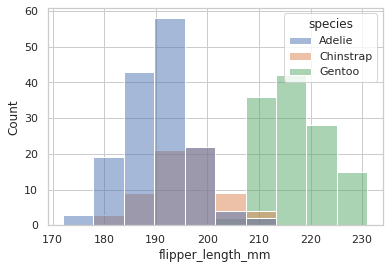

In [12]:
sns.__version__
penguins = sns.load_dataset("penguins")
sns.histplot(data=penguins, x="flipper_length_mm", hue="species")

Text(0.5, 1.0, 'Histogram of #(kp per document) of KP20k and MagKP')

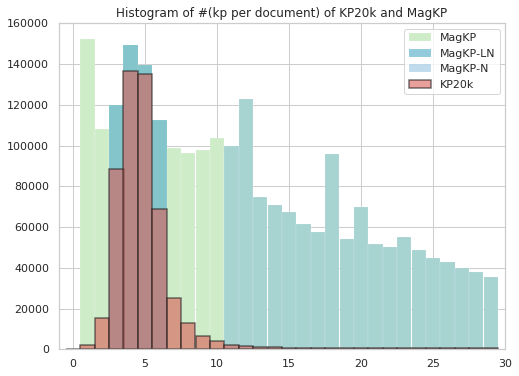

In [20]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n <= 30]
sns.distplot(tmp_tgt_nums, color=sns.color_palette("Greens_r", 8)[6], label="MagKP", bins=np.arange(31) - 0.5, kde=False, rug=False, hist_kws=dict(alpha=1.0, edgecolor="w", linewidth=0.2))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n >= 3 and n <= 6]
sns.distplot(tmp_tgt_nums, label="MagKP-LN", bins=np.arange(31)-0.5, 
             color="c",
             kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="w", linewidth=0.1))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n > 10 and n <= 30]
sns.distplot(tmp_tgt_nums, color=sns.color_palette("Blues_r", 8)[4], label="MagKP-N", bins=np.arange(31)-0.5, kde=False, rug=False, hist_kws=dict(alpha=0.5, edgecolor="w", linewidth=0.2))

tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n <= 30]
sns.distplot(tmp_tgt_nums, color=sns.color_palette("hls", 8)[0], label="KP20k", bins=np.arange(31) - 0.5, kde=False, rug=False, hist_kws=dict(alpha=0.6, edgecolor="k", linewidth=1.5))

plt.xlim([-1, 30])
plt.legend(loc='upper right')
ax.set_title('Histogram of #(kp per document) of KP20k and MagKP')

2391870
521542
1520307
521542
511653


Text(0.5, 0, '#(phrase) per paper')

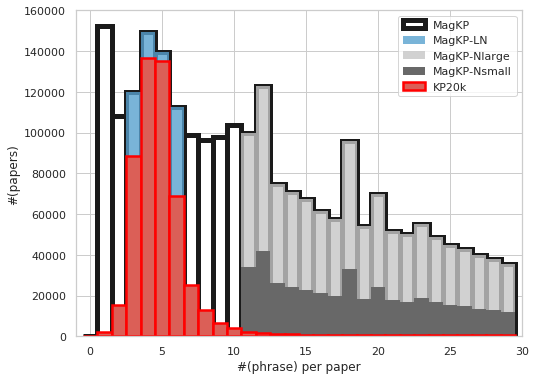

In [203]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n <= 30]
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="MagKP",
             bins=np.arange(31) - 0.5, color="w",
             hist_kws=dict(alpha=1.0, edgecolor="k", linewidth=5.0),
             kde=False, kde_kws={"color": "k", "lw": 3, "label": "KDE"})

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n >= 3 and n <= 6]
magkpln_tgt_nums = tmp_tgt_nums
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="MagKP-LN", 
             bins=np.arange(31)-0.5, color=sns.color_palette("Blues_r", 8)[3],
             kde=False, rug=False, hist_kws=dict(alpha=0.8, edgecolor="k", linewidth=0.0))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n > 10]
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="MagKP-Nlarge", 
             bins=np.arange(31)-0.5, color=sns.color_palette("Greys_r", 8)[5],
             kde=False, rug=False, hist_kws=dict(alpha=0.8, edgecolor="k", linewidth=0.0))


tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n > 10]
tmp_tgt_nums = tmp_tgt_nums[: len(magkpln_tgt_nums)]
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="MagKP-Nsmall", 
             bins=np.arange(31)-0.5, color=sns.color_palette("Greys_r", 8)[2],
             kde=False, rug=False, hist_kws=dict(alpha=1.0, edgecolor="k", linewidth=0.0))

tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n <= 30]
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="KP20k", 
             bins=np.arange(31) - 0.5, color=sns.color_palette("hls", 8)[0], 
             kde=False, rug=False, hist_kws=dict(alpha=1.0, edgecolor="red", linewidth=2.5))

plt.xlim([-1, 30])
plt.legend(loc='upper right')
ax.set_ylabel('#(papers)')
ax.set_xlabel('#(phrase) per paper')
# ax.set_title('Histogram of #(kp per document) of KP20k and MagKP')

#### Check #(unique_kp) in each dataset

In [3]:
dataset_names = ['kp20k', 'magkp']

# json_base_dir = '/Users/memray/project/kp/OpenNMT-kpg/data/keyphrase/json/' # path to the json folder
json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC

dataset_tgt_dict = {}
    
for dataset_name in dataset_names:
    dataset_tgt_dict[dataset_name] = []
    print(dataset_name)

    input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)
    
    with open(input_json_path, 'r') as input_json:
        for json_line in input_json:
            json_dict = json.loads(json_line)

            if dataset_name == 'stackexchange':
                json_dict['abstract'] = json_dict['question']
                json_dict['keywords'] = json_dict['tags']            
                del json_dict['question']
                del json_dict['tags']

            title = json_dict['title']
            abstract = json_dict['abstract']
            fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
            keywords = json_dict['keywords']

            if isinstance(keywords, str):
                keywords = keywords.split(';')
                json_dict['keywords'] = keywords
            keywords = [k.lower().strip() for k in keywords]
            
            dataset_tgt_dict[dataset_name].append(keywords)


kp20k
magkp


In [5]:
# prepare Magkp subsets
dataset_tgt_dict['magkp_ln'] = [kps for kps in dataset_tgt_dict["magkp"] if len(kps) >= 3 and len(kps) <= 6]
dataset_tgt_dict['magkp_nlarge'] = [kps for kps in dataset_tgt_dict["magkp"] if len(kps) > 10]
dataset_tgt_dict['magkp_nsmall'] = dataset_tgt_dict['magkp_nlarge'][: len(dataset_tgt_dict['magkp_ln'])]


In [6]:

for dataset, kps_list in dataset_tgt_dict.items():
    kp_set = set()
    num_kp = 0
    max_kp_in_doc = 0
    max_len_kp = 0
    len_kp_list = []
    for kps in kps_list:
        for kp in kps:
            kp_set.add(kp)
            num_kp += 1
            num_word = len(kp.split())
            len_kp_list.append(num_word)
            if num_word > max_len_kp:
                max_len_kp = num_word
        if len(kps) > max_kp_in_doc:
            max_kp_in_doc = len(kps)
    num_unique_kp = len(kp_set)
    print('*' * 50)
    print(dataset)
    print('num_doc=', len(kps_list))
    print('num_unique_kp=', num_unique_kp)
    print('num_kp=', num_kp)
    print('len_kp=', np.mean(len_kp_list))
    print('max_kp_in_doc=', max_kp_in_doc)
    print('len_kp_list=', max_len_kp)
    

**************************************************
kp20k
num_doc= 514154
num_unique_kp= 699791
num_kp= 2710067
len_kp= 1.9230266262789812
max_kp_in_doc= 110
len_kp_list= 91
**************************************************
magkp
num_doc= 2699094
num_unique_kp= 6880853
num_kp= 41605964
len_kp= 3.4161944427005704
max_kp_in_doc= 438
len_kp_list= 100
**************************************************
magkp_ln
num_doc= 521542
num_unique_kp= 579244
num_kp= 2331072
len_kp= 2.726639932185707
max_kp_in_doc= 6
len_kp_list= 100
**************************************************
magkp_nlarge
num_doc= 1520307
num_unique_kp= 5784959
num_kp= 35525765
len_kp= 3.376301903702848
max_kp_in_doc= 438
len_kp_list= 100
**************************************************
magkp_nsmall
num_doc= 521542
num_unique_kp= 2236091
num_kp= 12193980
len_kp= 3.3652286620119107
max_kp_in_doc= 262
len_kp_list= 100


#### print num_paper binned by num_kp

In [5]:
tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n <= 30]
for bin_count in np.bincount(tmp_tgt_nums):
    print(bin_count)

0
1884
15433
88651
136732
135117
68930
25108
12786
6306
3871
2054
1517
1088
945
859
817
844
793
866
856
807
731
743
676
657
604
546
500
492
440


### Stats of KP20k

##### w/o preprocessing

All documents
- #(data examples)=514,154 
- #(KP)=2,710,067
- #(unique KP)=710,218
 
 
For documents whose \#(kp)>10
- #(DP)=19,336 (3.76%)
- #(KP)=401,763 (14.82%)
- #(unique KP)=52,176 (7.35%)


##### w/ preprocessing
All documents
- #(DP)=514,154
- #(KP)=2,710,067
- #(unique KP)=625,058 (diff between w/&w/o preprocessing: 85,160)

For documents whose \#(kp)>10
- #(DP)=19,336
- #(KP)=401,763 (14.82%)
- #(unique KP)=48,125 (7.70%, diff between w/&w/o preprocessing: 4,051)

#### Count #kp per document

In [20]:
data = tgt_nums["kp20k"]
print(scipy.stats.describe(data))

for p in np.linspace(0, 100, 101):
    percentile = np.percentile(data, p, interpolation='lower')
    print('Percentile@%.0f = %.6f' % (p, percentile))

DescribeResult(nobs=514154, minmax=(1, 110), mean=5.270924664594655, variance=14.141117540879774, skewness=5.39192287405869, kurtosis=40.41415445884668)
Percentile@0 = 1.000000
Percentile@1 = 2.000000
Percentile@2 = 2.000000
Percentile@3 = 2.000000
Percentile@4 = 3.000000
Percentile@5 = 3.000000
Percentile@6 = 3.000000
Percentile@7 = 3.000000
Percentile@8 = 3.000000
Percentile@9 = 3.000000
Percentile@10 = 3.000000
Percentile@11 = 3.000000
Percentile@12 = 3.000000
Percentile@13 = 3.000000
Percentile@14 = 3.000000
Percentile@15 = 3.000000
Percentile@16 = 3.000000
Percentile@17 = 3.000000
Percentile@18 = 3.000000
Percentile@19 = 3.000000
Percentile@20 = 3.000000
Percentile@21 = 4.000000
Percentile@22 = 4.000000
Percentile@23 = 4.000000
Percentile@24 = 4.000000
Percentile@25 = 4.000000
Percentile@26 = 4.000000
Percentile@27 = 4.000000
Percentile@28 = 4.000000
Percentile@29 = 4.000000
Percentile@30 = 4.000000
Percentile@31 = 4.000000
Percentile@32 = 4.000000
Percentile@33 = 4.000000
Percent

In [27]:
tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n >=3 and n <= 6]
print('%d/%d' % (len(tmp_tgt_nums), len(tgt_nums["kp20k"])))

429430/514154


Text(0.5, 1.0, 'Histogram of #(kp per document) of KP20k (truncated at 10)')

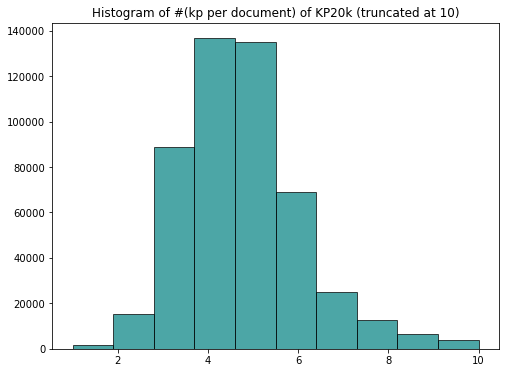

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n <= 10]
sns.distplot(tmp_tgt_nums, color="teal", label="KP20k", bins=10, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))

ax.set_title('Histogram of #(kp per document) of KP20k (truncated at 10)')

Text(0.5, 1.0, 'Histogram of #(kp per document) of KP20k')

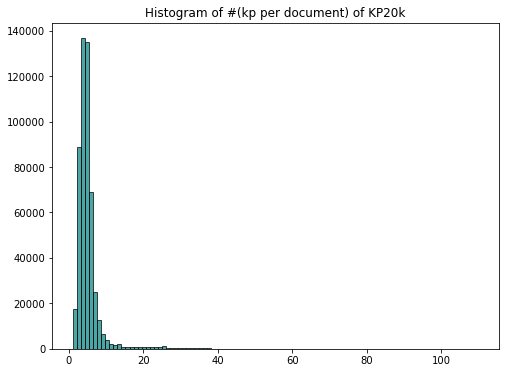

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["kp20k"]]
sns.distplot(tmp_tgt_nums, color="teal", label="KP20k", bins=100, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))

ax.set_title('Histogram of #(kp per document) of KP20k')

#### Count unique phrases

##### only count documents that #(kp)>10

In [30]:
dataset_name = 'kp20k'
do_preprocess = True

stemmer = PorterStemmer()
json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC
input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)

unique_kp_counter = defaultdict(lambda: 0)
num_data = 0
num_kp = 0

with open(input_json_path, 'r') as input_json:
    for json_line in input_json:
        json_dict = json.loads(json_line)

        if dataset_name == 'stackexchange':
            json_dict['abstract'] = json_dict['question']
            json_dict['keywords'] = json_dict['tags']            
            del json_dict['question']
            del json_dict['tags']

        title = json_dict['title']
        abstract = json_dict['abstract']
        fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
        keywords = json_dict['keywords']

        if isinstance(keywords, str):
            keywords = keywords.split(';')
            json_dict['keywords'] = keywords
        
        if len(keywords) > 10:
            num_data += 1
            for keyword in keywords:
                num_kp += 1
                if do_preprocess:
                    tokens = [stemmer.stem(t) for t in keyword.lower().split()]
                    keyword = '_'.join(tokens)
                    
                unique_kp_counter[keyword] = unique_kp_counter[keyword] + 1

print('#(DP)=%d' % num_data)
print('#(KP)=%d' % num_kp)
print('#(unique KP)=%d' % len(unique_kp_counter))

#(DP)=19336
#(KP)=401763
#(unique KP)=48125


#####  count all documents #(kp)>0

In [13]:
dataset_name = 'kp20k'
do_preprocess = False

stemmer = PorterStemmer()
json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC
input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)

unique_kp_counter = defaultdict(lambda: 0)
kp_len_counter = defaultdict(lambda: 0)
num_data = 0
num_kp = 0

with open(input_json_path, 'r') as input_json:
    for json_line in input_json:
        json_dict = json.loads(json_line)

        if dataset_name == 'stackexchange':
            json_dict['abstract'] = json_dict['question']
            json_dict['keywords'] = json_dict['tags']            
            del json_dict['question']
            del json_dict['tags']

        title = json_dict['title']
        abstract = json_dict['abstract']
        fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
        keywords = json_dict['keywords']

        if isinstance(keywords, str):
            keywords = keywords.split(';')
            json_dict['keywords'] = keywords
        
        if len(keywords) > 0:
            num_data += 1
            for keyword in keywords:
                num_kp += 1
                if do_preprocess:
                    tokens = [stemmer.stem(t) for t in keyword.lower().split()]
                    keyword = ' '.join(tokens)
                    
                tokens = [t for t in keyword.split()]
                kp_len_counter[len(tokens)] = kp_len_counter[len(tokens)] + 1
                unique_kp_counter[keyword] = unique_kp_counter[keyword] + 1

print('#(DP)=%d' % num_data)
print('#(KP)=%d' % num_kp)
print('#(unique KP)=%d' % len(unique_kp_counter))

#(DP)=514154
#(KP)=2710067
#(unique KP)=710218


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_kp_freqs = [v for k,v in unique_kp_counter.items() if v > 1000]
sns.distplot(tmp_kp_freqs, color="teal", label="KP20k", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))


####  KP length distribution

#kp_len=0, freq=63, accum/total=0.00%
#kp_len=1, freq=907946, accum/total=33.51%
#kp_len=2, freq=1267094, accum/total=80.26%
#kp_len=3, freq=418621, accum/total=95.71%
#kp_len=4, freq=87761, accum/total=98.95%
#kp_len=5, freq=19873, accum/total=99.68%
#kp_len=6, freq=5200, accum/total=99.87%
#kp_len=7, freq=1625, accum/total=99.93%
#kp_len=8, freq=670, accum/total=99.96%
#kp_len=9, freq=268, accum/total=99.97%
#kp_len=10, freq=147, accum/total=99.97%
#kp_len=11, freq=219, accum/total=99.98%
#kp_len=12, freq=234, accum/total=99.99%
#kp_len=13, freq=98, accum/total=99.99%
#kp_len=14, freq=38, accum/total=99.99%
#kp_len=15, freq=41, accum/total=99.99%
#kp_len=16, freq=30, accum/total=99.99%
#kp_len=17, freq=19, accum/total=100.00%
#kp_len=18, freq=9, accum/total=100.00%
#kp_len=19, freq=21, accum/total=100.00%
#kp_len=20, freq=14, accum/total=100.00%
#kp_len=21, freq=12, accum/total=100.00%
#kp_len=22, freq=5, accum/total=100.00%
#kp_len=23, freq=17, accum/total=100.00%
#kp_len=24, freq=1

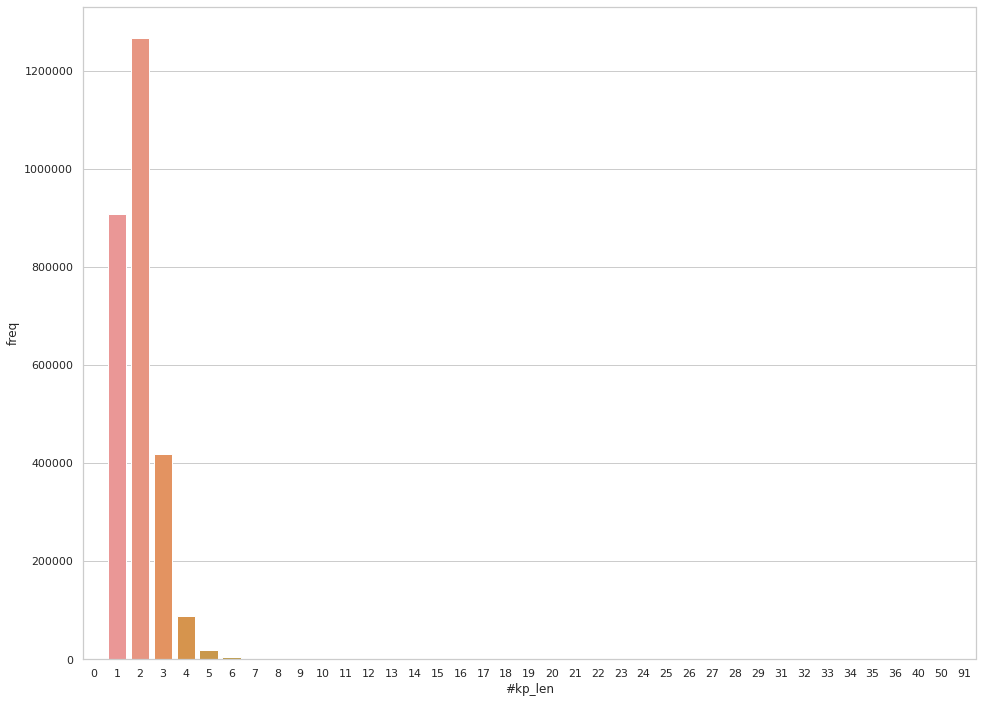

In [16]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.set(style="whitegrid")
kp_lens = sorted([(kp_len, freq) for kp_len, freq in kp_len_counter.items()], key=lambda k:k[0])

accum_kp_count = 0
total_kp_count = sum(freq for _, freq in kp_lens)
for kp_len, freq in kp_lens:
    accum_kp_count += freq
    print('#kp_len=%d, freq=%d, accum/total=%.2f%%' % (kp_len, freq, accum_kp_count / total_kp_count * 100))
    
print(len(kp_lens))
kp_lens_df = pd.DataFrame(kp_lens, columns=['#kp_len', 'freq'])
ax = sns.barplot(x="#kp_len", y="freq", data=kp_lens_df)


# Stats of MagKP

##### w/o preprocessing

All documents
- #(DP)=2,699,094
- #(KP)=41,605,964
- #(unique KP)=6,880,853

For documents whose \#(kp)>10
- #(DP)=1,520,307 (56.33%)
- #(KP)=35,525,765 (85.39%)
- #(unique KP)=5,784,959 (84.07%)

##### w/ preprocessing (lowercase and stemming)

All documents
- #(DP)=2,699,094
- #(KP)=41,605,964
- #(unique KP)=6,537,481 (diff between w/&w/o preprocessing: 343,372, 5.25% difference)

For documents whose \#(kp)>10
- #(DP)=1,520,307
- #(KP)=35,525,765 （85.39%）
- #(unique KP)=5,493,997 (84.04%, diff between w/&w/o preprocessing: 290,962)

### load data

In [2]:
dataset_names = ['kp20k', 'magkp']

# json_base_dir = '/Users/memray/project/kp/OpenNMT-kpg/data/keyphrase/json/' # path to the json folder
json_base_dir = '/zfs1/hdaqing/rum20/kp/data/kp/json' # path on CRC

dataset_examples = {}
    
for dataset_name in dataset_names:
    dataset_examples[dataset_name] = []
    print(dataset_name)

    input_json_path = os.path.join(json_base_dir, dataset_name, 'train.json')
    
    with open(input_json_path, 'r') as input_json:
        for json_line in input_json:
            ex_dict = json.loads(json_line)

            if dataset_name == 'stackexchange':
                ex_dict['abstract'] = ex_dict['question']
                ex_dict['keywords'] = ex_dict['tags']            
                del ex_dict['question']
                del ex_dict['tags']

            keywords = ex_dict['keywords']
            ex_dict['fulltext'] = ''

            if isinstance(keywords, str):
                keywords = keywords.split(';')
                ex_dict['keywords'] = keywords
            keywords = [k.strip() for k in keywords]
            ex_dict['keywords'] = keywords
            
            dataset_examples[dataset_name].append(ex_dict)


kp20k
magkp


### Check ratio of present/absent KPs

In [31]:
def if_present_phrase(src_str_tokens, phrase_str_tokens):
    """
    :param src_str_tokens: a list of strings (words) of source text
    :param phrase_str_tokens: a list of strings (words) of a phrase
    :return:
    """
    match_flag = False
    match_pos_idx = -1
    for src_start_idx in range(len(src_str_tokens) - len(phrase_str_tokens) + 1):
        match_flag = True
        # iterate each word in target, if one word does not match, set match=False and break
        for seq_idx, seq_w in enumerate(phrase_str_tokens):
            src_w = src_str_tokens[src_start_idx + seq_idx]
            if src_w != seq_w:
                match_flag = False
                break
        if match_flag:
            match_pos_idx = src_start_idx
            break

    return match_flag

stat_dicts = []

for start in range(0, 200, 10):
    unique_kp_set = set()
    num_total_kp, num_unique_kp, num_present_kp, num_absent_kp = 0, 0, 0, 0
    exs = [ex for ex in dataset_examples["magkp"] if len(ex['keywords']) >= start and len(ex['keywords']) < start + 10]
    for ex_id, ex in enumerate(exs):
        for p in ex['keywords']:
            unique_kp_set.add(p)
            num_total_kp += 1
            src_tokens = (ex['title'] + ' ' + ex['abstract']).lower().split()
            tgt_tokens = p.lower().split()
            if if_present_phrase(src_tokens, tgt_tokens):
                num_present_kp += 1
            else:
                num_absent_kp += 1
#         if ex_id > 1000:
#             break
          
    stat = {
        'kp_range': '[%d, %d]' % (start, start + 10),
        'num_doc': len(exs),
        'num_total_kp': num_total_kp,
        'num_unique_kp': len(unique_kp_set),
        'ratio_unique_kp': len(unique_kp_set) / num_total_kp,
        'num_present_kp': num_present_kp,
        'ratio_present_kp': num_present_kp / num_total_kp,
        'num_absent_kp': num_absent_kp,
        'ratio_absent_kp': num_absent_kp / num_total_kp,
    }

    stat_dicts.append(stat)
    for k, v in stat.items():
        if k == 'kp_range':
            print(k, '=', v)
        elif k.startswith('ratio'):
            print('\t', k, '=', '%.2f%%' % (v * 100.0))
        else:
            print('\t', k, '=', v)
        

kp_range = [0, 10]
	 num_doc = 1075018
	 num_total_kp = 5042509
	 num_unique_kp = 1177502
	 ratio_unique_kp = 23.35%
	 num_present_kp = 1624703
	 ratio_present_kp = 32.22%
	 num_absent_kp = 3417806
	 ratio_absent_kp = 67.78%
kp_range = [10, 20]
	 num_doc = 808194
	 num_total_kp = 11297261
	 num_unique_kp = 2128224
	 ratio_unique_kp = 18.84%
	 num_present_kp = 2225699
	 ratio_present_kp = 19.70%
	 num_absent_kp = 9071562
	 ratio_absent_kp = 80.30%
kp_range = [20, 30]
	 num_doc = 476153
	 num_total_kp = 11417185
	 num_unique_kp = 2294995
	 ratio_unique_kp = 20.10%
	 num_present_kp = 2459860
	 ratio_present_kp = 21.55%
	 num_absent_kp = 8957325
	 ratio_absent_kp = 78.45%
kp_range = [30, 40]
	 num_doc = 215045
	 num_total_kp = 7232686
	 num_unique_kp = 1580889
	 ratio_unique_kp = 21.86%
	 num_present_kp = 1669954
	 ratio_present_kp = 23.09%
	 num_absent_kp = 5562732
	 ratio_absent_kp = 76.91%
kp_range = [40, 50]
	 num_doc = 69542
	 num_total_kp = 3033018
	 num_unique_kp = 572174
	 ratio_un

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

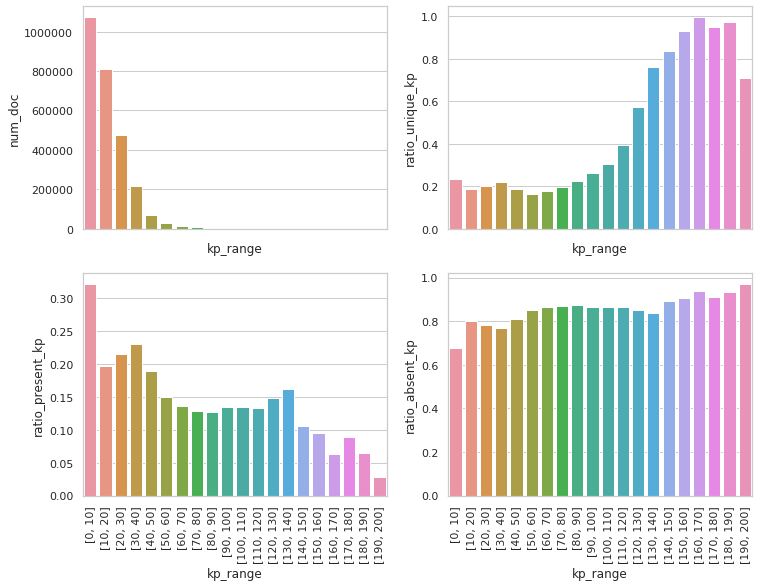

In [32]:
kpstat_df = pd.DataFrame(stat_dicts, columns=list(stat_dicts[0].keys()))

import seaborn as sns
import matplotlib.pyplot as plt
fig, axes=plt.subplots(2, 2, figsize=(12, 9))

sns.set_theme(style="whitegrid")
g = sns.barplot(x="kp_range", y="num_doc", data=kpstat_df, ax=axes[0, 0])
g.set(xticklabels=[])

g = sns.barplot(x="kp_range", y="ratio_unique_kp", data=kpstat_df, ax=axes[0, 1])
g.set(xticklabels=[])

g = sns.barplot(x="kp_range", y="ratio_present_kp", data=kpstat_df, ax=axes[1, 0])
plt.setp(g.get_xticklabels(), rotation=90)

g = sns.barplot(x="kp_range", y="ratio_absent_kp", data=kpstat_df, ax=axes[1, 1])
plt.setp(g.get_xticklabels(), rotation=90)


kp_range = [0, 5]
	 num_doc = 242700
	 num_total_kp = 845631
	 num_unique_kp = 318082
	 ratio_unique_kp = 37.61%
	 num_present_kp = 404802
	 ratio_present_kp = 47.87%
	 num_absent_kp = 440829
	 ratio_absent_kp = 52.13%
kp_range = [5, 10]
	 num_doc = 248247
	 num_total_kp = 1423963
	 num_unique_kp = 467033
	 ratio_unique_kp = 32.80%
	 num_present_kp = 618408
	 ratio_present_kp = 43.43%
	 num_absent_kp = 805555
	 ratio_absent_kp = 56.57%
kp_range = [10, 15]
	 num_doc = 9475
	 num_total_kp = 106882
	 num_unique_kp = 48461
	 ratio_unique_kp = 45.34%
	 num_present_kp = 39789
	 ratio_present_kp = 37.23%
	 num_absent_kp = 67093
	 ratio_absent_kp = 62.77%
kp_range = [15, 20]
	 num_doc = 4179
	 num_total_kp = 71033
	 num_unique_kp = 12502
	 ratio_unique_kp = 17.60%
	 num_present_kp = 33997
	 ratio_present_kp = 47.86%
	 num_absent_kp = 37036
	 ratio_absent_kp = 52.14%
kp_range = [20, 25]
	 num_doc = 3813
	 num_total_kp = 83462
	 num_unique_kp = 8837
	 ratio_unique_kp = 10.59%
	 num_present_kp = 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

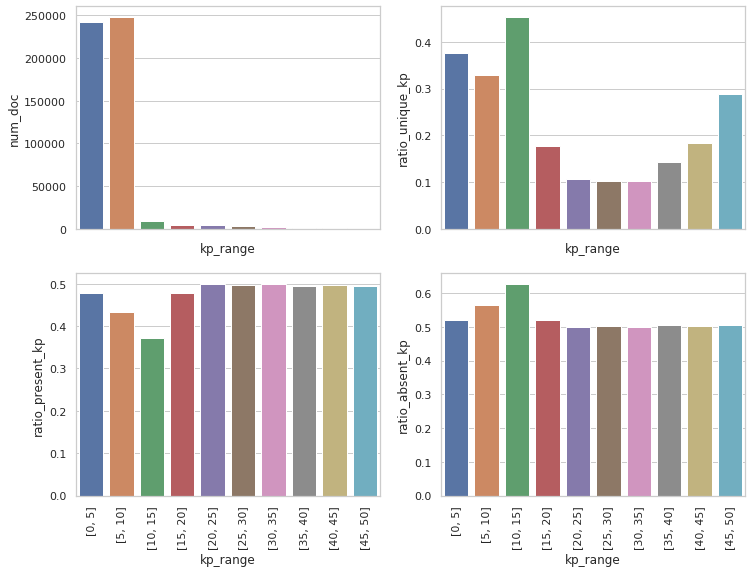

In [34]:
stat_dicts = []
step_size = 5

for start in range(0, 50, step_size):
    unique_kp_set = set()
    num_total_kp, num_unique_kp, num_present_kp, num_absent_kp = 0, 0, 0, 0
    exs = [ex for ex in dataset_examples["kp20k"] if len(ex['keywords']) >= start and len(ex['keywords']) < start + step_size]
    for ex_id, ex in enumerate(exs):
        for p in ex['keywords']:
            unique_kp_set.add(p)
            num_total_kp += 1
            src_tokens = (ex['title'] + ' ' + ex['abstract']).lower().split()
            tgt_tokens = p.lower().split()
            if if_present_phrase(src_tokens, tgt_tokens):
                num_present_kp += 1
            else:
                num_absent_kp += 1
#         if ex_id > 1000:
#             break
          
    stat = {
        'kp_range': '[%d, %d]' % (start, start + step_size),
        'num_doc': len(exs),
        'num_total_kp': num_total_kp,
        'num_unique_kp': len(unique_kp_set),
        'ratio_unique_kp': len(unique_kp_set) / num_total_kp,
        'num_present_kp': num_present_kp,
        'ratio_present_kp': num_present_kp / num_total_kp,
        'num_absent_kp': num_absent_kp,
        'ratio_absent_kp': num_absent_kp / num_total_kp,
    }

    stat_dicts.append(stat)
    for k, v in stat.items():
        if k == 'kp_range':
            print(k, '=', v)
        elif k.startswith('ratio'):
            print('\t', k, '=', '%.2f%%' % (v * 100.0))
        else:
            print('\t', k, '=', v)
        
kpstat_df = pd.DataFrame(stat_dicts, columns=list(stat_dicts[0].keys()))

import seaborn as sns
import matplotlib.pyplot as plt
fig, axes=plt.subplots(2, 2, figsize=(12, 9))

sns.set_theme(style="whitegrid")
g = sns.barplot(x="kp_range", y="num_doc", data=kpstat_df, ax=axes[0, 0])
g.set(xticklabels=[])

g = sns.barplot(x="kp_range", y="ratio_unique_kp", data=kpstat_df, ax=axes[0, 1])
g.set(xticklabels=[])

g = sns.barplot(x="kp_range", y="ratio_present_kp", data=kpstat_df, ax=axes[1, 0])
plt.setp(g.get_xticklabels(), rotation=90)

g = sns.barplot(x="kp_range", y="ratio_absent_kp", data=kpstat_df, ax=axes[1, 1])
plt.setp(g.get_xticklabels(), rotation=90)


### Manually examine examples containing too many phrases (e.g. >20, **num_noisy_examples= 745916**)
 - All phrases are lowercased.
 - All hyphens/parentheses are removed. But words in parentheses are preserved.
 - Found phrases in French (imagerie medicale, ondelette), Spanish (analisis datos) etc.
 - It appears that MagKP contains a lot of data from IEEE which contain a lot of errors. (**num_contain_long_kps=514582**)
     - 4 groups: IEEE Keywords, INSPEC: Controlled Indexing, INSPEC: Non-Controlled Indexing, and author keywords
     - it often contains some wrong and very long phrases, concatenation of multiple phrases. This can be easily filtered by phrase length.
         e.g. https://ieeexplore.ieee.org/abstract/document/4101114/keywords#keywords, "normalized random number area efficient architecture large scale implementation biological neural networks plausible neural networks spiking neural networks reconfigurable hardware multiplier less hardware architecture single fpga synaptic multiplication and gate"
     - Oftentimes it doesn't completely match the record on IEEE website. Say "membrane potential" and "integrate and fire" appear in the abstract, but not in any of keyword fields.
 - Also some papers do not have keywords originally. Very likely they are automatically annotated? (**num_no_long_kps=231334**)
     - say 'id': 'dbe8cad4-3c1f-4414-95a0-338c7cb3184d', https://www.sciencedirect.com/science/article/pii/S1077201404000452
     - 'id': 'dde7b89e-5251-4991-9e3a-7c7191a20240', https://link.springer.com/chapter/10.1007/11925941_1
         "These keywords were added by machine and not by the authors. This process is experimental and the keywords may be updated as the learning algorithm improves."
 - Some have original keywords, but still many are new.
     - 'id': 'dc7b584d-66f5-4ae5-bc21-e38715fd7403', https://www.sciencedirect.com/science/article/pii/0045790694900175

In [34]:
exs = [ex for ex in dataset_examples["magkp"] if len(ex['keywords']) > 20]
exs = sorted(exs, key=lambda x: len(ex['keywords']))
print(len(exs))

745916


In [37]:
exs[50]

{'id': 'dbe06305-ce86-46da-b693-7ae062acc315',
 'title': 'A novel adaptive routing scheme for the QoS-based multimedia services in mobile ad-hoc networks',
 'abstract': 'A mobile ad-hoc network is composed of only mobile nodes, which are distributed dynamically, without any wired backbone or centralized entities. Since the existing works on ad-hoc routing protocol are mostly biased toward a military application, we need a new routing scheme for the support of multimedia services in mobile ad-hoc networks. Therefore, we propose a novel scheme that can support a variety of traffic attributes and can be applicable to high-speed and multimedia data services in mobile ad-hoc networks by using adaptive transmission power level. As a result of simulation, the proposed scheme has better performance than conventional method, which is performed with uniform transmission power level, in view of route query delay time',
 'keywords': ['land mobile radio quality of service multimedia communication t

### Check if all the phrases are lowercase? yes

In [36]:
num_pure_lower_kps, num_non_lower_kps = 0, 0
num_hyphen_kps, num_bracket_kps = 0, 0
for ex in dataset_examples["magkp"]:
    for kp in ex['keywords']:
        if kp.lower() == kp:
            num_pure_lower_kps += 1
        else:
            num_non_lower_kps += 1
        if '-' in kp:
            num_hyphen_kps += 1
        if '(' in kp or ')' in kp:
            num_bracket_kps += 1
            
print('num_pure_lower_kps=', num_pure_lower_kps)
print('num_non_lower_kps=', num_non_lower_kps)

print('num_hyphen_kps=', num_hyphen_kps)
print('num_bracket_kps=', num_bracket_kps)


num_pure_lower_kps= 41605964
num_non_lower_kps= 0
num_hyphen_kps= 0
num_bracket_kps= 0


### Check if all noisy MagKP examples are from IEEE? No, likely 68.99%

Assume all IEEE data examples contain certain number of very long phrases (>=10 words, due to the mistaken concatenation of multiple phrases).

In [41]:
exs = [ex for ex in dataset_examples["magkp"] if len(ex['keywords']) > 20]
exs = sorted(exs, key=lambda x: len(ex['keywords']))
no_long_exs = []

print('num_noisy_examples=', len(exs))

num_contain_long_kps, num_no_long_kps = 0, 0

for ex in exs:
    found_long_kp = False
    for kp in ex['keywords']:
        if len(kp.split()) >= 10:
            found_long_kp = True
            break
    if found_long_kp:
        num_contain_long_kps += 1
    else:
        num_no_long_kps += 1
        no_long_exs.append(ex)
        
print('num_contain_long_kps=', num_contain_long_kps)
print('num_no_long_kps=', num_no_long_kps)


num_noisy_examples= 745916
num_contain_long_kps= 514582
num_no_long_kps= 231334


In [ ]:
no_long_exs[105500]

#### Count #kp per document

In [24]:
tgt_nums = [len(ex['keywords']) for ex in dataset_examples["magkp"]]
data = tgt_nums
print(scipy.stats.describe(data))

for p in np.linspace(0, 100, 101):
    percentile = np.percentile(data, p, interpolation='lower')
    print('Percentile@%.0f = %.6f' % (p, percentile))

DescribeResult(nobs=2699094, minmax=(1, 438), mean=15.414788814320657, variance=168.752782332351, skewness=1.8635894274050995, kurtosis=7.294107031214651)
Percentile@0 = 1.000000
Percentile@1 = 1.000000
Percentile@2 = 1.000000
Percentile@3 = 1.000000
Percentile@4 = 1.000000
Percentile@5 = 1.000000
Percentile@6 = 2.000000
Percentile@7 = 2.000000
Percentile@8 = 2.000000
Percentile@9 = 2.000000
Percentile@10 = 3.000000
Percentile@11 = 3.000000
Percentile@12 = 3.000000
Percentile@13 = 3.000000
Percentile@14 = 3.000000
Percentile@15 = 4.000000
Percentile@16 = 4.000000
Percentile@17 = 4.000000
Percentile@18 = 4.000000
Percentile@19 = 4.000000
Percentile@20 = 5.000000
Percentile@21 = 5.000000
Percentile@22 = 5.000000
Percentile@23 = 5.000000
Percentile@24 = 5.000000
Percentile@25 = 6.000000
Percentile@26 = 6.000000
Percentile@27 = 6.000000
Percentile@28 = 6.000000
Percentile@29 = 7.000000
Percentile@30 = 7.000000
Percentile@31 = 7.000000
Percentile@32 = 7.000000
Percentile@33 = 8.000000
Perce

#### Histogram of #(kp per document) < 61

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of #(kp per document) of MagKP (truncated at 60)')

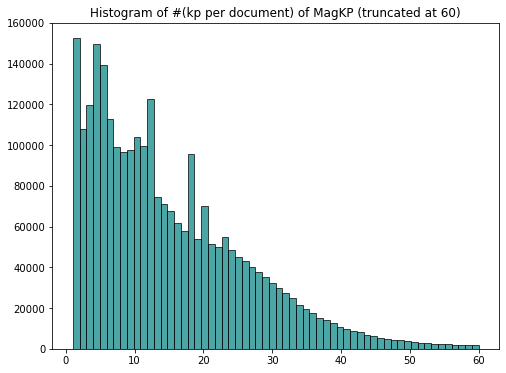

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n < 61]
sns.distplot(tmp_tgt_nums, color="teal", label="MagKP", bins=60, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))

ax.set_title('Histogram of #(kp per document) of MagKP (truncated at 60)')

#### Histogram of #(kp per document) < 11

Text(0.5, 1.0, 'Histogram of #(kp per document) of MagKP (truncated at 10)')

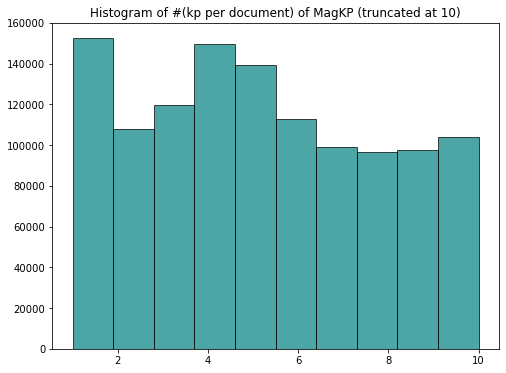

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n <= 10]
sns.distplot(tmp_tgt_nums, color="teal", label="MagKP", bins=10, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))

ax.set_title('Histogram of #(kp per document) of MagKP (truncated at 10)')

Text(0.5, 1.0, 'Histogram of #(kp per document) of MagKP (truncated at 60)')

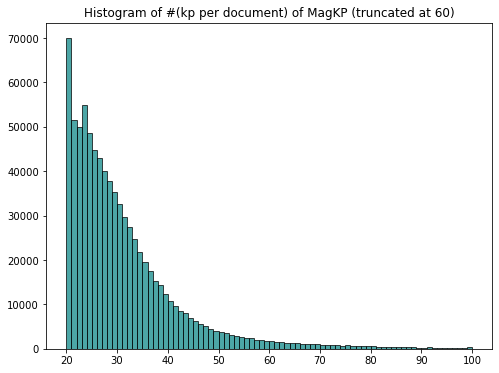

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n>=20 and n <= 100]
sns.distplot(tmp_tgt_nums, color="teal", label="MagKP", bins=80, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))

ax.set_title('Histogram of #(kp per document) of MagKP (truncated at 60)')

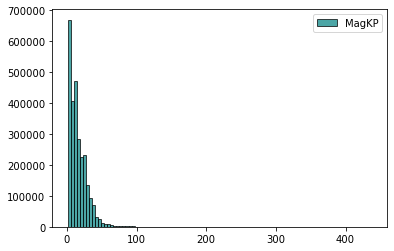

In [15]:
#     sns.distplot(np.asarray(tgt_nums, dtype=int), bins=15, color="r", kde=False, rug=False);
    
    # Plot a simple histogram with binsize determined automatically
#     sns.distplot(tgt_nums, kde=False, color="b", ax=ax)

#     # Plot a kernel density estimate and rug plot
#     sns.distplot(tgt_nums, hist=False, rug=True, color="r")

#     # Plot a filled kernel density estimate
#     sns.distplot(tgt_nums, hist=False, color="g", kde_kws={"shade": True})

#     # Plot a histogram and kernel density estimate
#     sns.distplot(tgt_nums, hist=True, color="m", ax=ax)
    
# sns.distplot(tgt_nums["kp20k"] , color="skyblue", label="KP20k", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))
# sns.distplot(tgt_nums["kp20k"] , color="teal", label="KP20k", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))
sns.distplot(tgt_nums["magkp"] , color="teal", label="MagKP", bins=100, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))
# sns.distplot(tgt_nums["inspec"] , color="red", label="Inspec", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))
# sns.distplot(tgt_nums["krapivin"] , color="olive", label="Krapivin", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))
# sns.distplot(tgt_nums["nus"] , color="gold", label="NUS", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))
# sns.distplot(tgt_nums["semeval"] , color="teal", label="Semeval", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))

ax.set(xlabel='Number of keyphrases in doc', ylabel='Number of documents')
plt.legend()
plt.show()


#### Count unique phrases

##### only count documents that #(kp)>10

In [20]:
do_preprocess = True
stemmer = PorterStemmer()

unique_kp_counter = defaultdict(lambda: 0)
num_data = 0
num_kp = 0

for ex_dict in dataset_tgt_dict['magkp']:
    title = json_dict['title']
    abstract = json_dict['abstract']
    fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
    keywords = json_dict['keywords']

    if isinstance(keywords, str):
        keywords = keywords.split(';')
        json_dict['keywords'] = keywords

    if len(keywords) > 10:
        num_data += 1
        for keyword in keywords:
            num_kp += 1
            if do_preprocess:
                tokens = [stemmer.stem(t) for t in keyword.lower().split()]
                keyword = '_'.join(tokens)

            unique_kp_counter[keyword] = unique_kp_counter[keyword] + 1

print('#(DP)=%d' % num_data)
print('#(KP)=%d' % num_kp)
print('#(unique KP)=%d' % len(unique_kp_counter))

#(DP)=2699094
#(KP)=29690034
#(unique KP)=11


#####  count all documents #(kp)>0

In [17]:
dataset_name = 'magkp'
do_preprocess = False

stemmer = PorterStemmer()

json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC
input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)

unique_kp_counter = defaultdict(lambda: 0)
kp_len_counter = defaultdict(lambda: 0)
num_data = 0
num_kp = 0

with open(input_json_path, 'r') as input_json:
    for json_line in input_json:
        json_dict = json.loads(json_line)

        if dataset_name == 'stackexchange':
            json_dict['abstract'] = json_dict['question']
            json_dict['keywords'] = json_dict['tags']            
            del json_dict['question']
            del json_dict['tags']

        title = json_dict['title']
        abstract = json_dict['abstract']
        fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
        keywords = json_dict['keywords']

        if isinstance(keywords, str):
            keywords = keywords.split(';')
            json_dict['keywords'] = keywords
            
        if len(keywords) > 0:
            num_data += 1
            for keyword in keywords:
                num_kp += 1
                if do_preprocess:
                    tokens = [stemmer.stem(t) for t in keyword.lower().split()]
                    keyword = ' '.join(tokens)
#                 print(keyword)
                
                tokens = [t for t in keyword.split()]
                kp_len_counter[len(tokens)] = kp_len_counter[len(tokens)] + 1
                unique_kp_counter[keyword] = unique_kp_counter[keyword] + 1

print('#(DP)=%d' % num_data)
print('#(KP)=%d' % num_kp)
print('#(unique KP)=%d' % len(unique_kp_counter))

#(DP)=2699094
#(KP)=41605964
#(unique KP)=6880853


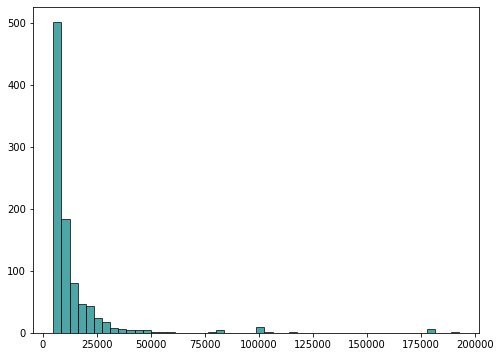

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_kp_freqs = [v for k,v in unique_kp_counter.items() if v > 5000]
sns.distplot(tmp_kp_freqs, color="teal", 
             title="Frequency of unique phrases", label="MagKP",
             bins=50, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))


####  KP length distribution

#kp_len=1, freq=7813072, accum/total=18.78%
#kp_len=2, freq=21476033, accum/total=70.40%
#kp_len=3, freq=6337508, accum/total=85.63%
#kp_len=4, freq=1705544, accum/total=89.73%
#kp_len=5, freq=502647, accum/total=90.94%
#kp_len=6, freq=281022, accum/total=91.61%
#kp_len=7, freq=217690, accum/total=92.13%
#kp_len=8, freq=230406, accum/total=92.69%
#kp_len=9, freq=226450, accum/total=93.23%
#kp_len=10, freq=226740, accum/total=93.78%
#kp_len=11, freq=216440, accum/total=94.30%
#kp_len=12, freq=195025, accum/total=94.77%
#kp_len=13, freq=171045, accum/total=95.18%
#kp_len=14, freq=154596, accum/total=95.55%
#kp_len=15, freq=146705, accum/total=95.90%
#kp_len=16, freq=150455, accum/total=96.26%
#kp_len=17, freq=159578, accum/total=96.65%
#kp_len=18, freq=164405, accum/total=97.04%
#kp_len=19, freq=158950, accum/total=97.42%
#kp_len=20, freq=142297, accum/total=97.77%
#kp_len=21, freq=119340, accum/total=98.05%
#kp_len=22, freq=95724, accum/total=98.28%
#kp_len=23, freq=75454, accum/total=9

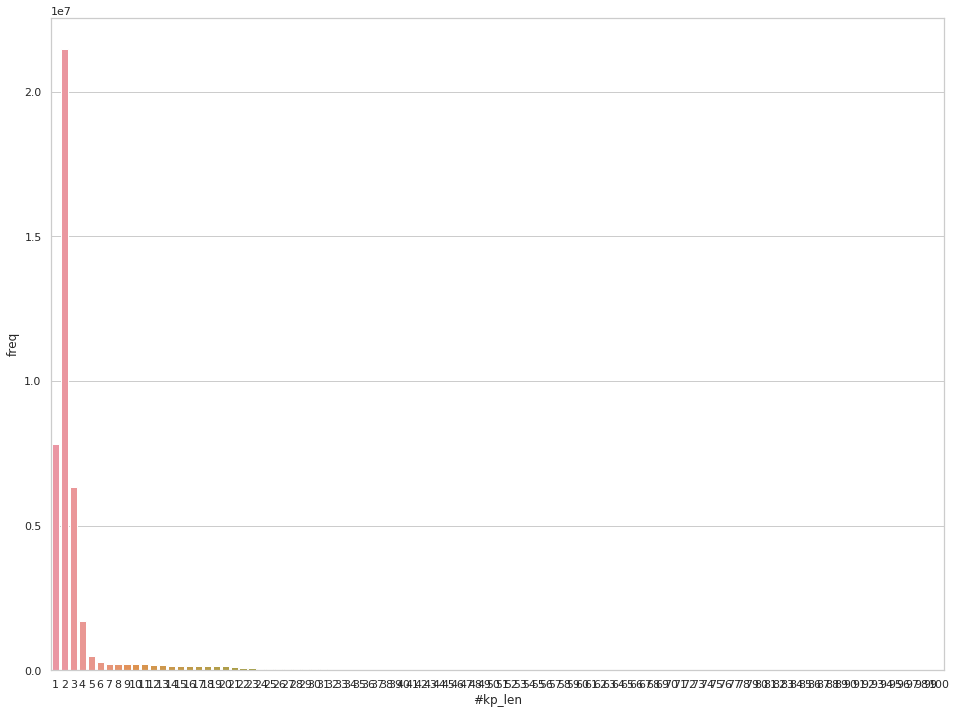

In [18]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.set(style="whitegrid")
kp_lens = sorted([(kp_len, freq) for kp_len, freq in kp_len_counter.items()], key=lambda k:k[0])

accum_kp_count = 0
total_kp_count = sum(freq for _, freq in kp_lens)
for kp_len, freq in kp_lens:
    accum_kp_count += freq
    print('#kp_len=%d, freq=%d, accum/total=%.2f%%' % (kp_len, freq, accum_kp_count / total_kp_count * 100))
    
print(len(kp_lens))
kp_lens_df = pd.DataFrame(kp_lens, columns=['#kp_len', 'freq'])
ax = sns.barplot(x="#kp_len", y="freq", data=kp_lens_df)
